In [3]:
import glob
import itertools
import sqlite3
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.auto import tqdm
import pathlib

In [26]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
colordict = {
    "GasCCS": "#b20101",
    "Gas": "#d35050",
    "HydroRes": "#08ad97",
    "HydroRoR": "#4adbc8",
    "OnWind": "#235ebc",
    "Solar": "#f9d002",
    "Import": "#8a1caf",
    "Windoffshore": "#6895dd",
    "Lion": "#baf238",
    "PumpedHydro": "#51dbcc",
}

In [5]:
colordict

{'GasCCS': '#b20101',
 'Gas': '#d35050',
 'HydroRes': '#08ad97',
 'HydroRoR': '#4adbc8',
 'OnWind': '#235ebc',
 'Solar': '#f9d002',
 'Import': '#8a1caf',
 'Windoffshore': '#6895dd',
 'Lion': '#baf238',
 'PumpedHydro': '#51dbcc'}

In [6]:
compressionfileending = ".zstd"
compressiondict = {"method": "zstd", "level": 19, "threads": -1}

In [18]:
resultspath = pathlib.Path(
    #"/c/Users/javedm/highRES-Europe-WF/work"
    "C:\\Users\\javedm\\highRES-Europe-WF\\work"
)
resultspath

WindowsPath('C:/Users/javedm/highRES-Europe-WF/work')

In [10]:
def modelstatus(modelpath):
    logfile = modelpath/"highres.log"
    gamsfile = modelpath/"results.gdx"
    database = modelpath/"results.db"

    if logfile.is_file() and gamsfile.is_file() and database.is_file():
        with open (logfile) as logfile:
            if "Optimal solution found" in logfile.read():
                return "optimal"
            else:
                return "exists"
    else:
        return "missing"


In [35]:
requested_scenarios = pd.read_csv(
    resultspath/"scenarios.csv", sep="\t", keep_default_na=False, index_col=0
).assign(
    path=lambda df: (
        resultspath
        / "models"
        / df.years.astype(str)
        / (
            df.spatials.astype(str)
#           + "_"
#            + df.years.astype(str)
        )
    ),
    status=lambda df:df.path.apply(modelstatus),
)

In [27]:
pd.set_option('display.max_colwidth', None)
requested_scenarios["path"]


0    C:\Users\javedm\highRES-Europe-WF\work\models\2010\region
Name: path, dtype: object

In [36]:
requested_scenarios

,years,spatials,path,status
0,2010,region,C:\Users\javedm\highRES-Europe-WF\work\models\2010\region,optimal


In [29]:
requested_scenarios.query("status != 'optimal'")

,years,spatials,path,status


In [30]:
found_scenarios = list((resultspath/"models").rglob("results.db"))

In [31]:
found_scenarios

[WindowsPath('C:/Users/javedm/highRES-Europe-WF/work/models/2010/region/results.db')]

In [69]:
def makenice(scenariolist, parameter):
    returnlist = []
    
    basicindexlist = ["year", "Spatial"]

    if parameter == "cost":
        table = "scalarvariables"
        index = ["name"]
        newindex = ["variable"]
        extraindex = newindex + ["level_1"]
        value = "costs"
        types = {}
        tabletype = "multiple"

    if parameter == "cap":
        table = "var_tot_pcap"      # variable name in GAMS model
        index = ["g"]
        newindex = ["technology"]
        extraindex = newindex + ["level_1"]
        value = "gencaptot"        # Variable value after optimization
        types = {}
        tabletype = "multiple"

    if parameter == "newcap":
        table = "var_new_pcap"
        index = ["g"]
        newindex = ["technology"]
        extraindex = newindex + ["level_1"]
        value = "gencapnew"
        types = {}
        tabletype = "multiple"

    if parameter == "gen":
        table = "var_gen"
        index = ["h", "z", "g"]
        newindex = ["hour", "zone", "technology"]
        extraindex = newindex + ["level_3"]
        value = "genamttot"
        types = {"hour": int}
        tabletype = "multiple"

    if parameter == "gentot":
        table = "o_gen_tot"
        index = ["g"]
        newindex = ["technology"]
        extraindex = newindex       #newindex+["level_1"]
        value = "genamttot"
        types = {}
        tabletype = "single"

    if parameter == "pgen":
        table = "var_pgen"
        index = ["h", "z"]
        newindex = ["hour", "zone"]
        extraindex = newindex + ["level_2"]
        value = "pgen"
        types = {"hour": int}
        tabletype = "multiple"

    if parameter == "pgenz":
        table = "o_pgen_tot_z"
        index = ["z"]
        newindex = ["zone"]
        extraindex = newindex       #newindex+["level_1"]
        value = "pgen"
        types = {}
        tabletype = "single"

    if parameter == "demand":
        table = "demand"
        index = ["z", "h"]
        newindex = ["zone", "hour"]
        extraindex = newindex
        value = "demand"
        types = {"hour": int}
        tabletype = "single"

    if parameter == "area":
        table = "area"
        index = ["vre", "z", "r"]
        newindex = ["technology", "zone", "region"]
        extraindex = newindex
        value = "area"
        types = {}
        tabletype = "single"

    if parameter == "storage_pcap":
        table = "var_tot_store_pcap"
        index = ["s"]
        newindex = ["technology"]
        extraindex = newindex + ["level_1"]
        value = "storepcaptot"
        types = {}
        tabletype = "multiple"

    if parameter == "storage_ecap":
        table = "var_tot_store_ecap"
        index = ["s"]
        newindex = ["technology"]
        extraindex = newindex + ["level_1"]
        value = "storeecaptot"
        types = {}
        tabletype = "multiple"

    if parameter == "storage_gen_tot":
        table = "o_store_gen_all"
        index = ["s"]
        newindex = ["technology"]
        extraindex = newindex
        value = "storegentot"
        types = {}
        tabletype = "single"

    if parameter == "vre_gen":
        table = "vre_gen"
        index = ["h", "vre", "r"]
        newindex = ["hour", "technology", "region"]
        extraindex = newindex
        value = "capfac"
        types = {}
        tabletype = "single"

    if parameter == "costsgencapex":
        table = "costs_gen_capex"
        index = ["z"]
        newindex = ["zone"]
        extraindex = newindex + ["level_1"]
        value = "costsgencapex"
        types = {}
        tabletype = "multiple"

    if parameter == "costsgenvarom":
        table = "costs_gen_varom"
        index = ["z"]
        newindex = ["zone"]
        extraindex = newindex + ["level_1"]
        value = "costsgenvarom"
        types = {}
        tabletype = "multiple"

    indexlist = basicindexlist  + extraindex
    indexdict = dict(zip(index, newindex))
    indexdict.update({0: value})
    for scenario in tqdm(scenariolist):
        scenarioname = str(scenario)[64+8: -6]     #need to set these numbers according to the path
        scenarioname = '2010_' + scenarioname + '_region'   # checkagain
        scenarionamesplit = scenarioname[0:].split("_") # set accordingly, output ['rio', 'results']

        con = sqlite3.connect(scenario)
        appendme = pd.read_sql_query(f"SELECT * from {table}", con)
        
        # It only executes on following two lines
        if tabletype == "multiple":
            appendme = appendme.set_index(index).stack().reset_index()
        appendme = (
            appendme.rename(columns=indexdict)
            .assign(
                year=scenarioname[:4],
                Spatial=scenarionamesplit[2],   #changed
            )
            .astype(types)
            .set_index(indexlist)
            .sort_index()
        )
        returnlist.append(appendme)
        con.close()
    return pd.concat(returnlist)
    

    

In [79]:
def barplot(inputdf):
    return(
        inputdf.groupby(
            ["year", "Spatial"]
        )
        .sum()
        .reset_index()
        .assign(
            name=lambda df: df.year.astype(str)
            + "_"
            + df.Spatial
        )
        .set_index("name")
        .sort_index()
        .loc[:,"value"]
        .plot.barh(figsize=(8,5), logx=True)
    )

In [73]:
sqlite_list = requested_scenarios.query("status == 'optimal'").path / "results.db"
sqlite_list

0    C:\Users\javedm\highRES-Europe-WF\work\models\2010\region\results.db
Name: path, dtype: object

In [74]:
dem = makenice(sqlite_list, "demand")

100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


In [75]:
dem

value
year Spatial zone hour         
2010 region  AT   0     10.6494
                  1     10.4538
                  2     10.2650
                  3     10.7076
                  4     11.8622
...                         ...
             UK   8755  89.2896
                  8756  83.7368
                  8757  76.6974
                  8758  69.5452
                  8759  62.3398

[245280 rows x 1 columns]

<Axes: ylabel='name'>

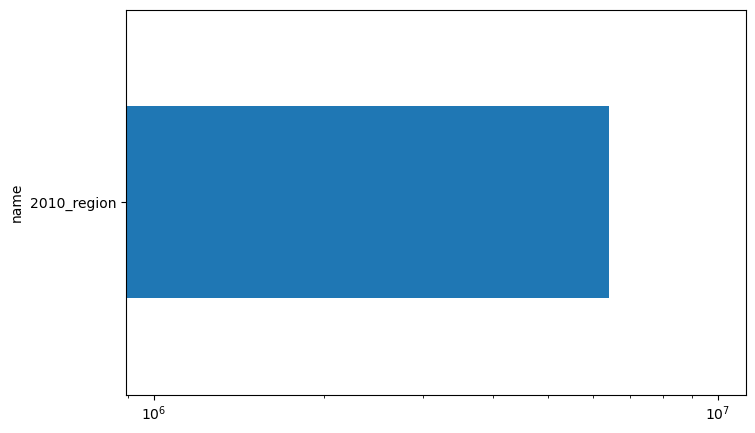

In [80]:
barplot(dem)

In [82]:
dem = pd.DataFrame()
dem

""


In [ ]:
# scenarios_short are not defined
for scenario in scenarios_short:
    print("data/" + scenario + ".db")
    con = sqlite3.connect("data/" + str(scenario) + ".db")
    temp = (
        pd.read_sql_query("SELECT * from demand", con)
        .rename(columns={"z": "zone", "h": "hour", "value": "demand_GWh"})
        .groupby("zone")
        .sum()
    )
    temp["scenario"] = scenario
    frames = [dem, temp]
    dem = pd.concat(frames)


In [ ]:
dem = dem.reset_index().set_index(["scenario", "zone"])

In [87]:
#Area
area = makenice(sqlite_list, "area")
area

100%|██████████| 1/1 [00:00<00:00, 62.43it/s]


value
year Spatial technology  zone region               
2010 region  HydroRoR    AT   AT      1.000000e+100
                         BE   BE      1.000000e+100
                         BG   BG      1.000000e+100
                         CH   CH      1.000000e+100
                         CZ   CZ      1.000000e+100
...                                             ...
             Windonshore PT   PT       1.340256e+02
                         RO   RO       1.353153e+02
                         SE   SE       9.481518e+02
                         SK   SK       3.295650e+01
                         UK   UK       6.254349e+02

[102 rows x 1 columns]

In [97]:
# querying specific technology with defined scenarios
(
    area.groupby(
        ["year", "Spatial", "technology"]
    )
    .sum()
    .query("technology == 'Windonshore'")
    .sort_values("value")
)

,,,value
year,Spatial,technology,
2010,region,Windonshore,8078.205


<Axes: ylabel='name'>

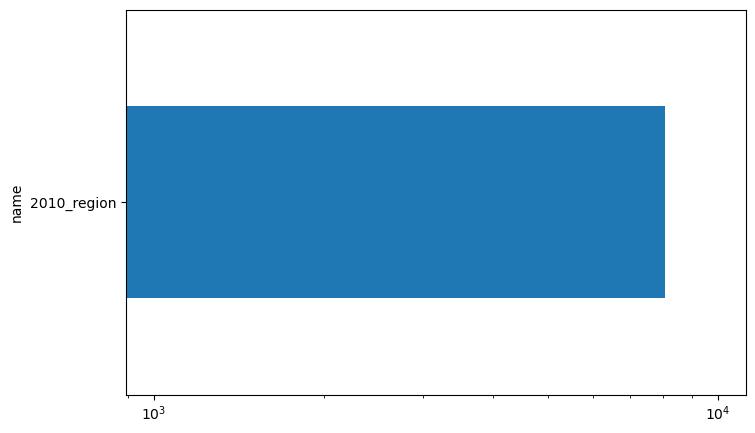

In [102]:
barplot(
    area.groupby(
        ["year", "Spatial", "technology"]
    )
    .sum()
    .query("technology == 'Windonshore'")   # Could be filtered any technology here
)

In [103]:
# Generation

gentot = makenice(sqlite_list, "gentot")
gentot

100%|██████████| 1/1 [00:00<00:00, 62.29it/s]


value
year Spatial technology                
2010 region  HydroRes      3.111921e+05
             HydroRoR      1.343183e+05
             Solar         2.860303e+06
             Windoffshore  2.846780e+06
             Windonshore   5.403913e+05

In [104]:
colordict

{'GasCCS': '#b20101',
 'Gas': '#d35050',
 'HydroRes': '#08ad97',
 'HydroRoR': '#4adbc8',
 'OnWind': '#235ebc',
 'Solar': '#f9d002',
 'Import': '#8a1caf',
 'Windoffshore': '#6895dd',
 'Lion': '#baf238',
 'PumpedHydro': '#51dbcc'}

<Axes: title={'center': 'EU electrictiy generation without Hydro 2030'}, xlabel='GWh', ylabel='year,Spatial'>

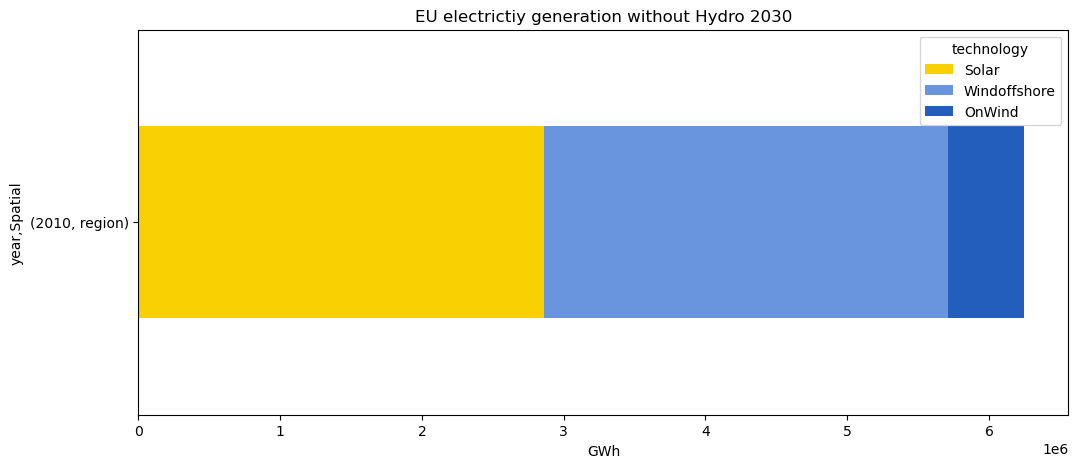

In [116]:
scale = 1
(
    gentot.query(
        "year == '2010'"
    )
    .unstack()
    .loc[:, "value"]
    .loc[:, ["Solar", "Windoffshore", "Windonshore"]]
    .sort_index()
    #.sort_values(["Windonshore"])
    .rename(columns={"Windonshore": "OnWind"})
    .plot.barh(
        stacked = True,
        title = "EU electrictiy generation without Hydro 2030",
        xlabel = "GWh",
        figsize = (12 / scale, 5 / scale),
        color = colordict,
    )
)

<Axes: ylabel='name'>

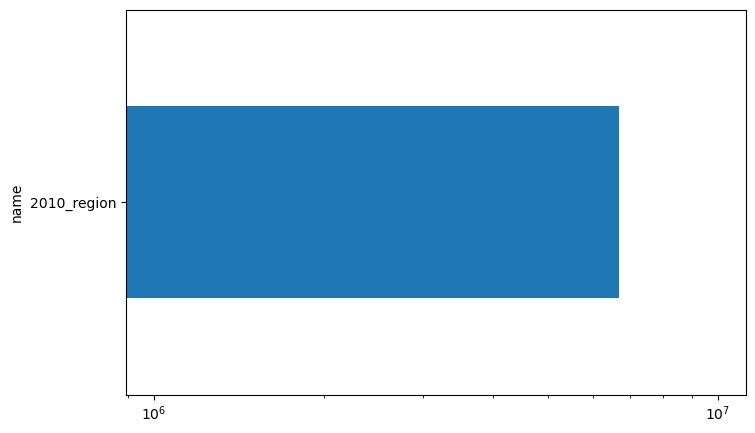

In [117]:
barplot(gentot)

In [ ]:
# not added the import scenario results analysis as gentot didnot contain the import as technology

In [118]:
storage_gen_tot = makenice(sqlite_list, "storage_gen_tot")

100%|██████████| 1/1 [00:00<00:00, 147.67it/s]


In [130]:
storage_gen_tot

value
year Spatial technology                
2010 region  Li-ion-8     980274.443059
             PumpedHydro    3015.155335

In [119]:
# Genration hourly
gen = makenice(sqlite_list, "gen")

100%|██████████| 1/1 [00:11<00:00, 11.92s/it]


In [120]:
gen

genamttot
year Spatial hour zone technology   level_3                
2010 region  0    AT   HydroRes     level      4.180217e-04
                                    lo         0.000000e+00
                                    marginal   5.115027e-06
                                    up        1.000000e+100
                       HydroRoR     level      1.274820e+00
...                                                     ...
             8759 UK   Windoffshore up        1.000000e+100
                       Windonshore  level      2.343273e-06
                                    lo         0.000000e+00
                                    marginal   0.000000e+00
                                    up        1.000000e+100

[6587520 rows x 1 columns]

In [ ]:
#zstandard package need to be install for compression process
gen.to_csv(
    "gen.csv" + compressionfileending, compression=compressiondict
)

In [123]:
#Storage
storetot = makenice(sqlite_list, "storage_pcap")

100%|██████████| 1/1 [00:00<00:00, 62.74it/s]


In [124]:
storetot

storepcaptot
year Spatial technology  level_1                
2010 region  Li-ion-8    level      7.111182e+02
                         lo         0.000000e+00
                         marginal   0.000000e+00
                         up        1.000000e+100
             PumpedHydro level      4.397681e+01
                         lo         0.000000e+00
                         marginal   0.000000e+00
                         up        1.000000e+100

<Axes: title={'center': 'EU electrictiy storage capcacity 2030'}, xlabel='GW', ylabel='year,Spatial'>

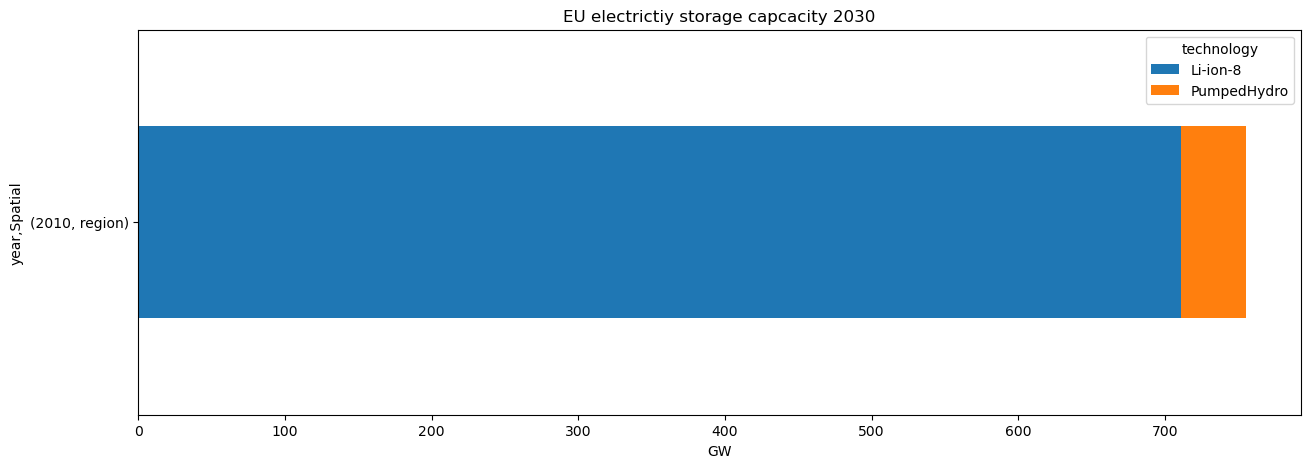

In [128]:
(
    storetot.query("level_1 == 'level'")
    .droplevel("level_1")
    .unstack()
    .loc[:, "storepcaptot"] #.loc choosing only storepcaptot column (all of its sub_columns are choosen)
    # .loc[:,["Import","Solar","Windoffshore","Windonshore"]]
    # .sort_values(["Windonshore"])
    # .rename(columns={"Windonshore":"OnWind"})
    .plot.barh(
        stacked=True,
        title="EU electrictiy storage capcacity 2030",
        # ylabel="Scenario",
        xlabel="GW",
        figsize=(15 / scale, 5 / scale),
        # color=colordict        
    )
)

In [129]:
storetot

storepcaptot
year Spatial technology  level_1                
2010 region  Li-ion-8    level      7.111182e+02
                         lo         0.000000e+00
                         marginal   0.000000e+00
                         up        1.000000e+100
             PumpedHydro level      4.397681e+01
                         lo         0.000000e+00
                         marginal   0.000000e+00
                         up        1.000000e+100

In [131]:
gentot

value
year Spatial technology                
2010 region  HydroRes      3.111921e+05
             HydroRoR      1.343183e+05
             Solar         2.860303e+06
             Windoffshore  2.846780e+06
             Windonshore   5.403913e+05

In [132]:
storage_gen_tot

value
year Spatial technology                
2010 region  Li-ion-8     980274.443059
             PumpedHydro    3015.155335

In [136]:
(
    pd.concat([gentot, storage_gen_tot.rename(columns={"storecaptot":"value"})])
    .unstack()
    .loc[:, "value"]
    .rename(columns={"Li-ion-8": "Lion", "Windonshore": "OnWind"})
    .drop(columns=["HydroRes", "HydroRoR"])
    #.query("Neigh == 'None'")
    # .iloc[-3:,:]
    # .query("Solar == 'Low'")
    # .plot.barh(
    #    stacked=True,
    #    title="Norwegian electricity generation 2030",
    #    # ylabel="Scenario",
    #    xlabel="GWh",
    #    figsize=(21.533 / scale, 12.582 / scale),
    #    color=colordict,
)

,technology,Lion,PumpedHydro,Solar,Windoffshore,OnWind
year,Spatial,,,,,
2010,region,980274.443059,3015.155335,2.860303e+06,2.846780e+06,540391.317512


In [140]:
#Need to refine further
result = pd.concat([gentot, storetot])
result

value   storepcaptot
year Spatial technology                               
2010 region  HydroRes      3.111921e+05            NaN
             HydroRoR      1.343183e+05            NaN
             Solar         2.860303e+06            NaN
             Windoffshore  2.846780e+06            NaN
             Windonshore   5.403913e+05            NaN
             Li-ion-8               NaN   7.111182e+02
             Li-ion-8               NaN   0.000000e+00
             Li-ion-8               NaN   0.000000e+00
             Li-ion-8               NaN  1.000000e+100
             PumpedHydro            NaN   4.397681e+01
             PumpedHydro            NaN   0.000000e+00
             PumpedHydro            NaN   0.000000e+00
             PumpedHydro            NaN  1.000000e+100

In [142]:
#costs
costs = makenice(sqlite_list, "cost")
costs

100%|██████████| 1/1 [00:00<00:00, 69.84it/s]


costs
year Spatial variable level_1                
2010 region  costs    level      3.603045e+05
                      lo       -1.000000e+100
                      marginal   0.000000e+00
                      up        1.000000e+100

In [144]:
costs.query('level_1 == "level"')

,,,,costs
year,Spatial,variable,level_1,
2010,region,costs,level,360304.547708


<Axes: ylabel='name'>

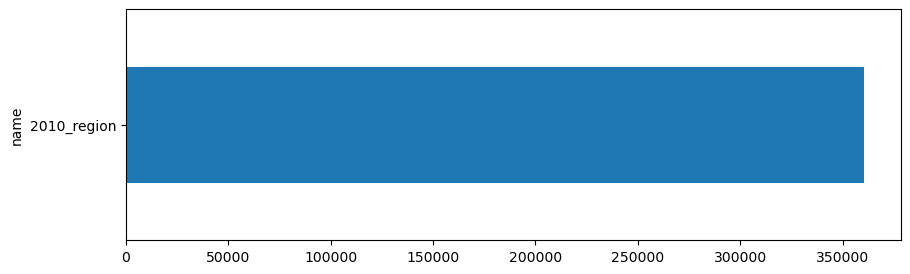

In [153]:
(
    costs.reset_index()
    .assign(
        name=lambda df: df.year.astype(str)
        + "_"
        + df.Spatial
    )
    .query('level_1 == "level"')
    .drop(columns=["variable", "level_1"])
    .set_index("name")
    .sort_values(by="costs")
    .loc[:, "costs"]
    .plot.barh(figsize=(10, 3))
)

In [ ]:
#???
df_costs.loc[(slice(None), "var_system_costs", slice(None))]

In [154]:
# Capacity
caps = makenice(sqlite_list, "cap")
caps

100%|██████████| 1/1 [00:00<00:00, 49.41it/s]


gencaptot
year Spatial technology                 level_1                
2010 region  HydroRes                   level      9.400671e+01
                                        lo         0.000000e+00
                                        marginal   0.000000e+00
                                        up        1.000000e+100
             HydroRoR                   level      6.682853e+01
                                        lo         0.000000e+00
                                        marginal   0.000000e+00
                                        up        1.000000e+100
             NaturalgasCCGTwithCCSnewOT level      0.000000e+00
                                        lo         0.000000e+00
                                        marginal   0.000000e+00
                                        up        1.000000e+100
             NaturalgasOCGTnew          level      0.000000e+00
                                        lo         0.000000e+00
                                        marginal   0.000000e+00
                                        up        1.000000e+100
             Solar                      level      2.310850e+03
                                        lo         0.000000e+00
                                        marginal   0.000000e+00
                                        up        1.000000e+100
             Windoffshore               level      6.255290e+02
                                        lo         0.000000e+00
                                        marginal   0.000000e+00
                                        up        1.000000e+100
             Windonshore                level      1.193874e+03
                                        lo         0.000000e+00
                                        marginal   0.000000e+00
                                        up        1.000000e+100

In [160]:
(
    caps.query(
        "level_1 == 'level'"
    )
    .droplevel("level_1")
    .unstack()
    .loc[:, "gencaptot"]
    .loc[:, ["Solar", "Windoffshore", "Windonshore"]]
    .sort_index()
    .rename(
        columns={
            "NaturalgasCCGTwithCCSnewOT": "GasCCS",
            "NaturalgasOCGTnew": "Gas",
            "Windonshore": "OnWind",
        },
    )
    .query("year == '2010'")   
)

,technology,Solar,Windoffshore,OnWind
year,Spatial,,,
2010,region,2310.850277,625.529043,1193.873924


In [162]:
#New capacity
newcaps = makenice(sqlite_list, "newcap")
newcaps

100%|██████████| 1/1 [00:00<00:00, 65.36it/s]


gencapnew
year Spatial technology                 level_1                
2010 region  HydroRes                   level      0.000000e+00
                                        lo         0.000000e+00
                                        marginal   0.000000e+00
                                        up        1.000000e+100
             HydroRoR                   level      0.000000e+00
                                        lo         0.000000e+00
                                        marginal   0.000000e+00
                                        up        1.000000e+100
             NaturalgasCCGTwithCCSnewOT level      0.000000e+00
                                        lo         0.000000e+00
                                        marginal   0.000000e+00
                                        up        1.000000e+100
             NaturalgasOCGTnew          level      0.000000e+00
                                        lo         0.000000e+00
                                        marginal   0.000000e+00
                                        up        1.000000e+100
             Solar                      level      2.310850e+03
                                        lo         0.000000e+00
                                        marginal   0.000000e+00
                                        up        1.000000e+100
             Windoffshore               level      6.255290e+02
                                        lo         0.000000e+00
                                        marginal   0.000000e+00
                                        up        1.000000e+100
             Windonshore                level      1.193874e+03
                                        lo         0.000000e+00
                                        marginal   0.000000e+00
                                        up        1.000000e+100

In [164]:
(
    newcaps.reset_index()
    .assign(
        name=lambda df: df.year.astype(str)
        + "_"
        + df.Spatial
    )
    .query('level_1 == "level"')
    .drop(columns=["level_1"])
    .set_index("name")
    .sort_values(by="gencapnew")
    .loc[:, "gencapnew"]
    # .plot.barh(figsize=(10, 15))
)

name
2010_region       0.000000
2010_region       0.000000
2010_region       0.000000
2010_region       0.000000
2010_region     625.529043
2010_region    1193.873924
2010_region    2310.850277
Name: gencapnew, dtype: float64

In [166]:
#Storage energy capacity
e_cap_dfs = []
for scenario in tqdm (sqlite_list):
    if pathlib.Path(scenario).is_file():
        con = sqlite3.connect(scenario)
        e_cap_dfs.append(
            pd.read_sql_query("SELECT * from var_tot_store_ecap", con)
            # .set_index("g")
            # .rename(
            #    {
            #        "NaturalgasCCGTwithCCSnewOT": "GasCCS",
            #        "NaturalgasOCGTnew": "Gas",
            #        "Windonshore": "OnWind",
            #    },
            #    axis="index",
            # )
            # .loc[:, ["level"]]
            # .rename_axis(index={"g": "Technology"})
            # .rename(columns={"level": "installed_capacity_GW"})
            # .assign(scenario=scenario[64:-11])
            # .reset_index()
            # .set_index(["scenario", "Technology"])
            # .sort_index()            
        )
        con.close()
e_cap2 = pd.concat(e_cap_dfs)
del e_cap_dfs

100%|██████████| 1/1 [00:00<00:00, 49.98it/s]


In [167]:
e_cap2

,s,level,lo,up,marginal
0,PumpedHydro,1312.869000,0.0,1.000000e+100,0.0
1,Li-ion-8,5688.945893,0.0,1.000000e+100,0.0


In [185]:
# Storage power capacity
p_cap_dfs = []
for scenario in sqlite_list:
    if pathlib.Path(scenario).is_file():
        con = sqlite3.connect(scenario)
        p_cap_dfs.append(
            pd.read_sql_query("SELECT * from var_tot_pcap", con)
            .set_index("g")
            .rename(
                {
                    "NaturalgasCCGTwithCCSnewOT": "GasCCS",
                    "NaturalgasOCGTnew": "Gas",
                    "Windonshore": "OnWind",
                },
                axis="index",
            )
            .loc[:, ["level"]]
            .rename_axis(index={"g": "Technology"})
            .rename(columns={"level": "installed_capacity_GW"})
            .assign(scenario=str(scenario)[51: -11])
            .reset_index()
            .set_index(["scenario", "Technology"])
            .sort_index()
        )
        con.close()
p_cap2 = pd.concat(p_cap_dfs)
del p_cap_dfs
p_cap2

installed_capacity_GW
scenario Technology                         
region   Gas                        0.000000
         GasCCS                     0.000000
         HydroRes                  94.006710
         HydroRoR                  66.828530
         OnWind                  1193.873924
         Solar                   2310.850277
         Windoffshore             625.529043

In [191]:
p_cap2.index.get_level_values(1).unique()

Index(['Gas', 'GasCCS', 'HydroRes', 'HydroRoR', 'OnWind', 'Solar',
       'Windoffshore'],
      dtype='object', name='Technology')

<Axes: title={'center': 'EU installed generation capacity 2010'}, xlabel='GW', ylabel='Scenario'>

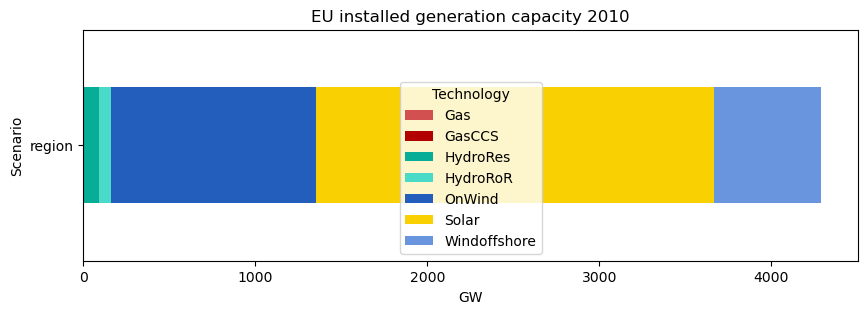

In [205]:
scale = 1
(
    p_cap2.reindex(
        p_cap2.groupby(["scenario"]).sum().sort_index()
        .index.to_list(),
        level=0,
    )
    .unstack()
    .loc[:, "installed_capacity_GW"]
    .plot.barh(
        stacked=True,
        title="EU installed generation capacity 2010",
        ylabel="Scenario",
        xlabel="GW",
        figsize=(10 / scale, 3 / scale),
        color=colordict,
    )    
)
# plt.savefig("output.svg", bbox_inches="tight")
# fig = plot.get_figure()
# fig.savefig("output.svg")

In [206]:
(p_cap2.unstack().loc[:, "installed_capacity_GW"])

Technology,Gas,GasCCS,HydroRes,HydroRoR,OnWind,Solar,Windoffshore
scenario,,,,,,,
region,0.0,0.0,94.00671,66.82853,1193.873924,2310.850277,625.529043


<Axes: title={'center': 'EU installed generation capacity (without hydro) 2010'}, xlabel='GW', ylabel='Scenario'>

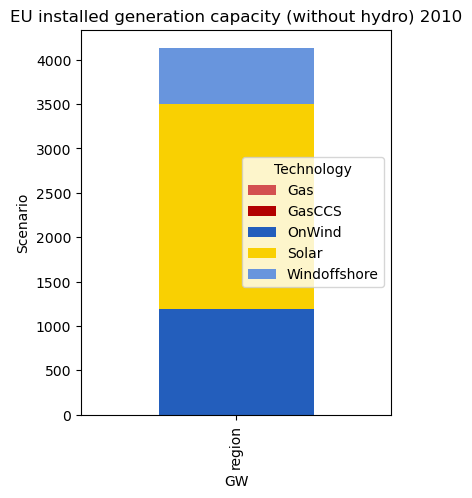

In [209]:
scale = 1
(
    p_cap2
    # .reindex(
    #    p_cap2.groupby(["scenario"])
    #    .sum()
    #    #.sort_index()
    #    .sort_values("installed_capacity_GW")
    #    .index.to_list(),
    #    level=0,
    # )
    .unstack()
    .loc[:, "installed_capacity_GW"]
    .loc[:, ["Gas", "GasCCS", "OnWind", "Solar", "Windoffshore"]]
    .plot.bar(
        stacked=True,
        title="EU installed generation capacity (without hydro) 2010",
        ylabel="Scenario",
        xlabel="GW",
        figsize=(4 / scale, 5 / scale),
        color=colordict,
    )
)

In [ ]:
# How much new transmission lines are there?

In [210]:
# capacity factors
capfacs = makenice(sqlite_list, "vre_gen")

100%|██████████| 1/1 [00:02<00:00,  2.30s/it]


In [211]:
capfacs

value
year Spatial hour technology  region       
2010 region  0    HydroRoR    AT       0.23
                              BE       0.30
                              CH       0.12
                              CZ       0.27
                              DE       0.37
...                                     ...
             999  Windonshore RO       0.39
                              SE       0.09
                              SI       0.00
                              SK       0.09
                              UK       0.31

[954840 rows x 1 columns]

In [215]:
meancapfacs = capfacs.groupby(
    [
        "year",
        "Spatial",
        "technology",
        "region",
    ]
).mean()
meancapfacs

value
year Spatial technology  region          
2010 region  HydroRoR    AT      0.496837
                         BE      0.308002
                         CH      0.317070
                         CZ      0.289105
                         DE      0.429287
...                                   ...
             Windonshore RO      0.182642
                         SE      0.196650
                         SI      0.000000
                         SK      0.204975
                         UK      0.281906

[109 rows x 1 columns]

In [217]:
meancapfacs.unstack().query(
    #"technology == 'Windonshore' and year == '2010' and ( Neigh == 'High' or Neigh == 'None') and Solar == 'Low'"
    "technology == 'Windonshore' and year == '2010'"
)

value                                     \
region                          AT        BE        BG   CH        CZ   
year Spatial technology                                                 
2010 region  Windonshore  0.202671  0.257879  0.193363  0.0  0.182341   

                                                                            \
region                          DE        DK        EE        ES        FI   
year Spatial technology                                                      
2010 region  Windonshore  0.212623  0.379947  0.264976  0.198692  0.183086   

                          ...                                          \
region                    ...        LV        NL        NO        PL   
year Spatial technology   ...                                           
2010 region  Windonshore  ...  0.238973  0.287373  0.235084  0.249607   

                                                                                
region                          PT        RO       SE   SI        SK        UK  
year Spatial technology                                                         
2010 region  Windonshore  0.209686  0.182642  0.19665  0.0  0.204975  0.281906  

[1 rows x 28 columns]

In [219]:
#costs
#Investments vs operations
costsgencapex = makenice(sqlite_list, "costsgencapex")
costsgencapex

100%|██████████| 1/1 [00:00<00:00, 94.01it/s]


costsgencapex
year Spatial zone level_1                
2010 region  AT   level      2.394180e+03
                  lo       -1.000000e+100
                  marginal   0.000000e+00
                  up        1.000000e+100
             BE   level      4.841089e-04
...                                   ...
             SK   up        1.000000e+100
             UK   level      4.215154e+03
                  lo       -1.000000e+100
                  marginal   0.000000e+00
                  up        1.000000e+100

[112 rows x 1 columns]

In [224]:
(costsgencapex.query("level_1 == 'level'").droplevel("level_1").unstack()
#.loc[:, "costsgencapex"]
#.query(
#    "year == '2010' and ( Neigh == 'High' or Neigh == 'None') and Solar == 'Low'"
).sum(axis=1)


year  Spatial
2010  region     177740.209426
dtype: float64

In [225]:
costsgenvarom = makenice(sqlite_list, "costsgenvarom")

100%|██████████| 1/1 [00:00<00:00, 102.39it/s]


In [226]:
(costsgenvarom.query("level_1 == 'level'").droplevel("level_1").unstack()
#.query(
#    "year == '2010' and ( Neigh == 'High' or Neigh == 'None') and Solar == 'Low'"
).sum(axis=1)


year  Spatial
2010  region     11253.24957
dtype: float64